# *Assignment #5*
## **[CSCI 581](https://www.ecst.csuchico.edu/~bjuliano/csci581/)**, Fall 2021

Feras Alshehri

# Identifying [handwritten digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

The [Digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset in [`sklearn`](https://scikit-learn.org/) has 1,797 samples with 64 numerical features ($8{\times}8$ pixels) and a 10-class target variable representing the digits 0 through 9.

# All dependencies
This is all the imports needed for this notebook

In [19]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Explore dataset
to get as better understanding of the dataset's content

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 64 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

<Figure size 432x288 with 0 Axes>

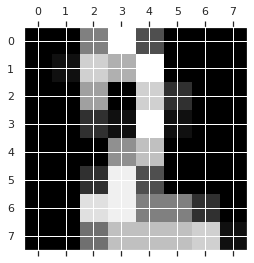


y[59] = 3


<Figure size 432x288 with 0 Axes>

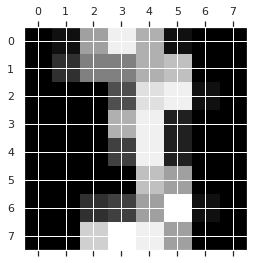


y[32] = 5


<Figure size 432x288 with 0 Axes>

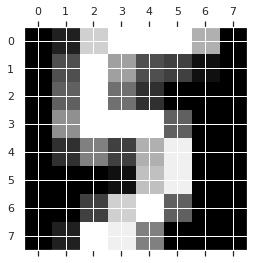


y[11] = 1


<Figure size 432x288 with 0 Axes>

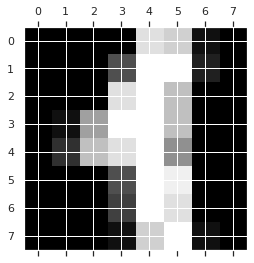


Possible target values = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


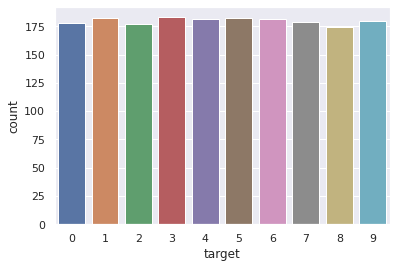

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64


<Figure size 432x288 with 0 Axes>

In [ ]:
# Load the Digits dataset
digits = load_digits(as_frame=1)

X = digits.data
y = digits.target

# overview of data
print('\n', digits.data.info())

# Check shape of X
print('\nX.shape =', X.shape)

# Each image is 8px by 8px that's why 64 pixels
print('\ndigits.images[4] =')
print(digits.images[4])

# Let's check a few particular target values
targetValues = [22, 59, 32, 11]

for val in targetValues:
    print(f'\ny[{val}] = {y[val]}')

    # Next, let's see how the image looks like
    plt.gray() 
    plt.matshow(digits.images[val]) 
    plt.show()
    plt.clf()

# check all unique possible target values
print(f'\nPossible target values = {set(digits.target)}')

# visualize any potential bias in the dataset towards a specific target value 
sns.countplot(digits.target)
plt.show()
plt.clf()

# print count of each value
print(digits.target.value_counts())

## Observation
* The data set includes a grey scale of pixels (8 by 8, or 46 pixels per image).
* each image represents a hand written integer. The integer is one of the following possible values:
  * Possible target values = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
* Each column (pixel position, per image) includes 1797 non-null values of type `float64`.
* The data set appears to have no specific bais towards a specific integer. the integer `3` has the most number samples (183), where the integer `8` has the least number of samples (174).

# Split the dataset for training and testing
The same test and training sub-datasets will be used for all models to ensure a normalized comparison.

In [13]:
# To apply an estimator (classifier) on this data, we flatten the image,
# to transform the data into a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X ,             # (samples,features) matrix
    y ,             # target values
    test_size=0.5 , # 50-50 split
    stratify = y,   # stratify to maintain original distribution of possible target values
    random_state=23 # constant value to ensure repeatibility
    )

# Helper functions
These function will be used to aid visualization throughout the nbotebook. 

In [ ]:
def addSubPlotConfusionMatrix(confMatrix, axes, target):
    ''' add a subplot in the form of a confusion matrix '''

    # conver to a df to easily plot it via seaborn as a heatmap
    df_cm = pd.DataFrame(confMatrix, index=['T','F'], 
                         columns=['P','N'])
    
    # create sub-plot object to be added to the high-level plot object
    subplot = sns.heatmap(df_cm, annot=True, square=True, 
                          cbar=False, fmt="d", ax=axes)

    # set up axis, title and labels of sub-plot at hand
    subplot.xaxis.set_ticklabels(subplot.xaxis.get_ticklabels(), 
                                 ha='right', fontsize=16)
    subplot.yaxis.set_ticklabels(subplot.yaxis.get_ticklabels(), 
                                 ha='right', fontsize=16)
    axes.set_title(f"Class {target}")
    axes.set_xlabel('Model Prediction')
    axes.set_ylabel('Ground Truth')

    return

## Part 1: Classification using a support vector machine

Generate a classification system for this problem using a *Support Vector Machine (SVM)*. You may refer to the [`sklearn_grid_search_digits.ipynb`](https://colab.research.google.com/gist/bjuliano/61e447bb95c4ab4b51288315ce09eeb8/sklearn_grid_search_digits.ipynb) Jupyter notebook example we discussed in class for hyperparameter settings for this estimator.

### Solution

In [ ]:
''' 
first, let's create an SVM classifier without grid search and see how it performs
with minimal varibles specified. Here we are only specifying the kernal type as linear.
'''

# create model with linear kernal
classifier = SVC(kernel='linear')

# train model
classifier.fit(X_train,y_train)

# predict target values using our trained model
y_pred = classifier.predict(X_test)

# show classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.93      0.98      0.95        91
           2       0.99      1.00      0.99        88
           3       0.98      0.97      0.97        92
           4       0.97      1.00      0.98        91
           5       0.93      0.98      0.95        91
           6       1.00      0.99      0.99        91
           7       0.99      0.97      0.98        89
           8       0.95      0.85      0.90        87
           9       0.94      0.93      0.94        90

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



Finding the best hyperparameters for our SVC classifier based on the best precision score
Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        88
           3       0.99      0.98      0.98        92
           4       1.00      1.00      1.00        91
           5       0.97      0.99      0.98        91
           6       1.00      0.99      0.99        91
           7       0.99      0.99      0.99        89
           8       1.00      0.98      0.99        87
           9       0.97      0.98      0.97        90

    accuracy                           0.99       899
   macro avg 

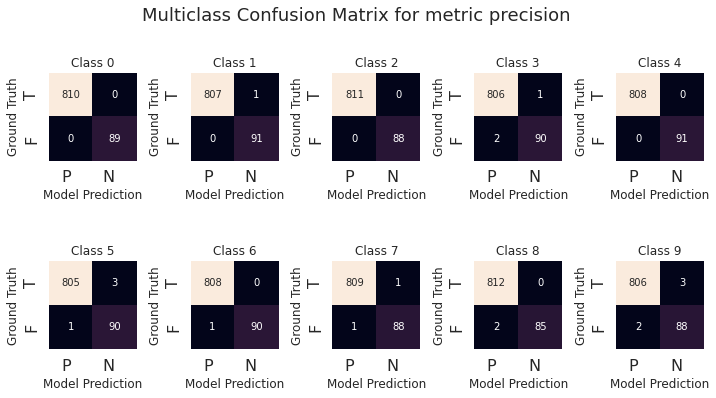


Finding the best hyperparameters for our SVC classifier based on the best recall score
Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        88
           3       0.99      0.98      0.98        92
           4       1.00      1.00      1.00        91
           5       0.97      0.99      0.98        91
           6       1.00      0.99      0.99        91
           7       0.99      0.99      0.99        89
           8       1.00      0.98      0.99        87
           9       0.97      0.98      0.97        90

    accuracy                           0.99       899
   macro avg   

<Figure size 432x288 with 0 Axes>

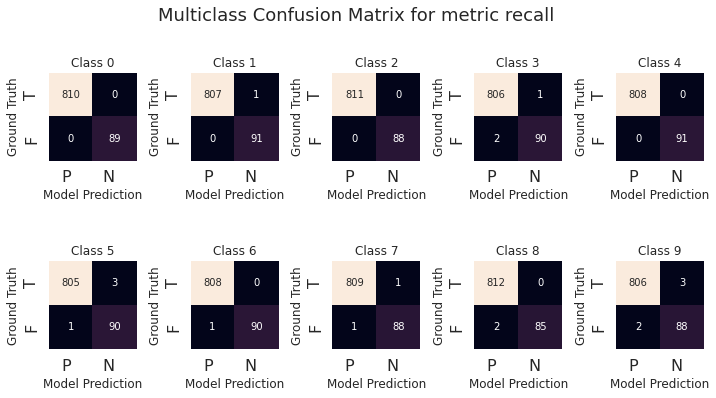


Finding the best hyperparameters for our SVC classifier based on the best f1 score
Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        88
           3       0.99      0.98      0.98        92
           4       1.00      1.00      1.00        91
           5       0.97      0.99      0.98        91
           6       1.00      0.99      0.99        91
           7       0.99      0.99      0.99        89
           8       1.00      0.98      0.99        87
           9       0.97      0.98      0.97        90

    accuracy                           0.99       899
   macro avg       

<Figure size 432x288 with 0 Axes>

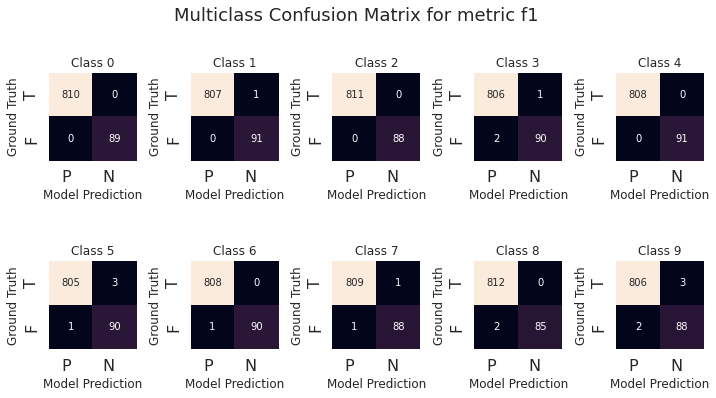


Finding the best hyperparameters for our SVC classifier based on the best jaccard score
Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        88
           3       0.99      0.98      0.98        92
           4       1.00      1.00      1.00        91
           5       0.97      0.99      0.98        91
           6       1.00      0.99      0.99        91
           7       0.99      0.99      0.99        89
           8       1.00      0.98      0.99        87
           9       0.97      0.98      0.97        90

    accuracy                           0.99       899
   macro avg  

<Figure size 432x288 with 0 Axes>

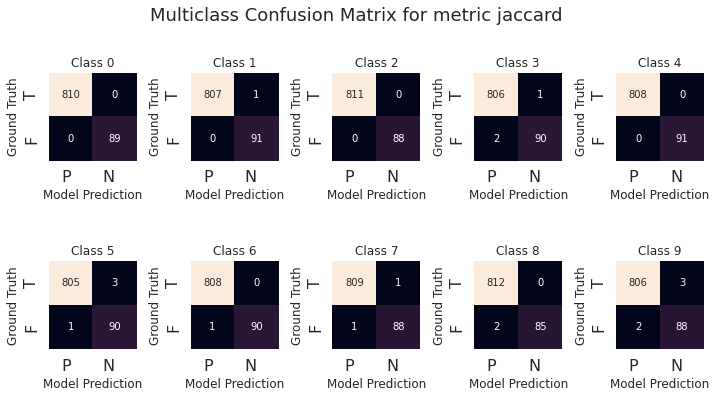


All possible results from our grid search for SVC classifier based on precision
	 0.986 (+/-0.013) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}
	 0.986 (+/-0.013) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}
	 0.967 (+/-0.015) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf', 'shrinking': True}
	 0.967 (+/-0.015) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf', 'shrinking': False}
	 0.988 (+/-0.013) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}
	 0.988 (+/-0.013) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}
	 0.987 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'shrinking': True}
	 0.987 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'shrinking': False}
	 0.988 (+/-0.013) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}
	 0.988 (+/-0.013) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}
	 0.984 (+/-0.015) for {'C': 100, 'gamma': 0.0001, 'kernel': '

<Figure size 432x288 with 0 Axes>

In [ ]:
''' 
now let's try to create the same type of classifier, but utilize grid search to tune 
the classifier's hyperparameters
'''

# grid search parameters range and search cases
# See all possible parameters and their types, possible combinations, and their impact:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
searchCases = [
    {"kernel": ["rbf"], 
        "gamma": [1e-3, 1e-4], # default=0.0
        "C": [1, 10, 100, 1000], # default=1.0
        "shrinking": [True, False]  # default=True
        },
    {"kernel": ["poly"], 
        "gamma": [1e-3, 1e-4], # default=0.0
        "C": [1, 10, 100, 1000], # default=1.0
        "degree": [1, 2, 3], # default=3
        "coef0": [0.0, 0.1, 1.0, 10.0],   # default=0.0
        "shrinking": [True, False]  # default=True
        },
    {"kernel": ["linear"],
        "C": [1, 10, 100, 1000], # default=1.0
        "shrinking": [True, False]  # default=True
        },
    {"kernel": ["sigmoid"],
        "C": [1, 10, 100, 1000], # default=1.0
        "degree": [1, 2, 3], # default=3
        "coef0": [0.0, 0.1, 1.0],   # default=0.0
        "shrinking": [True, False]  # default=True
        }
]

# these are the metrics we will use to rank each grid search result and 
# find the best possible outcome
metrics = ["precision", "recall", "f1", "jaccard"]
allResultsAllMetrics = []

for metric in metrics:
    allResultsPerMetric = []
    print(f"Finding the best hyperparameters for our SVC classifier based on the best {metric} score")

    # create model, and use grid search to tune the hyperparameters 
    classifier = GridSearchCV(SVC(), searchCases, scoring=f"{metric}_macro")
    
    # train model
    classifier.fit(X_train, y_train)

    # display best results found via grid search
    print(f"Best parameters set found on development set:\n{classifier.best_params_}\n\n")

    # display best parameters combination
    means = classifier.cv_results_["mean_test_score"]
    stds = classifier.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, classifier.cv_results_["params"]):
        allResultsPerMetric.append("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    # display detailed report of best case
    print("Detailed classification report:\n")
    print("The model is trained on the full development set.\n",
          "The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, classifier.predict(X_test)
    print(classification_report(y_true, y_pred), '\n\n')
    
    # plot confusion matrix
    fig, ax = plt.subplots(2, 5, figsize=(10, 6))
    for cfs_matrix, target, axes in zip(multilabel_confusion_matrix(y_true, y_pred),
                                        range(0,10),
                                        ax.flatten()):
        addSubPlotConfusionMatrix(cfs_matrix, axes, target)
    fig.suptitle(f'Multiclass Confusion Matrix for metric {metric}', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.clf()
    print()

    # append all result to the array to print it at the end
    allResultsAllMetrics.append(allResultsPerMetric)

# print all results (full verbosity)
for metric in range(len(allResultsAllMetrics)):
    print(f"All possible results from our grid search for SVC classifier based on {metrics[metric]}")
    for x in allResultsAllMetrics[metric]:
        print('\t', x)
    print()

### Observation
We ran an extensive grid search where possible for our dataset. The grid search foucsed on tuning the different parameters for different kenral types of our SVM classifier. All other parameters seemed to influnce the percesion of the SVM model based on the kernal type. For example, the parameter `gamma` has the most impact on SVM models with `rbf` or `poly` kernals, and the parameter `degree` has the most impact on SVM models with `poly` or `sigmoid` kernals.

Overall, we had the best parameters combination for all four metrics (percision, recall, f1-score, and Jaccard) at **0.988** (or 98.8%) with +/-0.013 stdv, except for Jaccard index metric where the best score was 0.976 (or 97.6%) with +/-0.025 stdv.
The best parameters combination for all metrics was as follows:
* `{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}`

However, it's worth noting that the following parameters combination also scored very close to the one stated above:
* `{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}`
* `{'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}`
* `{'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}`
* `{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True}`
* `{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': False}`

We can see that the parameters `C` and `shrinking` had little to no impact on this model and dataset with a Radial Basis Function (`rbf`) kernal; most of the impact is caused by the parameter `gamma`.


## Part 2: Classification using multinomial logistic regression

Generate a classification system for this problem using *multinomial Logistic Regression*. Refer to the [`sklearn_grid_search_digits.ipynb`](https://colab.research.google.com/gist/bjuliano/61e447bb95c4ab4b51288315ce09eeb8/sklearn_grid_search_digits.ipynb) Jupyter notebook example we discussed in class to tune the parameters for your estimator before building a model.

### Solution

recall that multinomial logistic regression is simply a binary logistic regression classifier for multiple classes instead of 2. This can be done by deviding the problem into subproblems, where each subproblem is classifying 2 classes (or 2 group of classes). This will allow us to apply binary logistic regression classifier, in a nested/recursive fashion, to solve a multi-class classification problem.

In [ ]:
''' 
first, let's create an MLR classifier without grid search and see how it performs
with minimal varibles specified. Here we are only specifying the multi_class to 
specifically account for the multiclass classification problem at hand (digits 0..9),
and max_iter as the default value (i.e., 100) causes a convergence warning due to 
reaching the maximum iteration limit and stopping prematurely.
'''

# create multinomial logistic regression model 
classifier = LogisticRegression(multi_class='multinomial', max_iter=1e4)

# train model
classifier.fit(X_train, y_train)

# predict target values using our trained model
y_pred = classifier.predict(X_test)

# show classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.96      0.95      0.95        91
           2       0.97      1.00      0.98        88
           3       1.00      0.92      0.96        92
           4       0.95      0.99      0.97        91
           5       0.91      0.98      0.94        91
           6       1.00      0.98      0.99        91
           7       1.00      0.96      0.98        89
           8       0.93      0.91      0.92        87
           9       0.93      0.96      0.95        90

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



Finding the best hyperparameters for our MLR classifier based on the best precision score
Best parameters set found on development set:
{'C': 1, 'fit_intercept': False, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 7, 'solver': 'saga', 'tol': 0.0001, 'warm_start': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        89
           1       0.92      0.96      0.94        91
           2       0.97      1.00      0.98        88
           3       1.00      0.96      0.98        92
           4       0.97      0.99      0.98        91
           5       0.93      0.97      0.95        91
           6       1.00      0.98      0.99        91
           7       1.00      0.96      0.98        89
           8       0.93      0.86      0.89        87
          

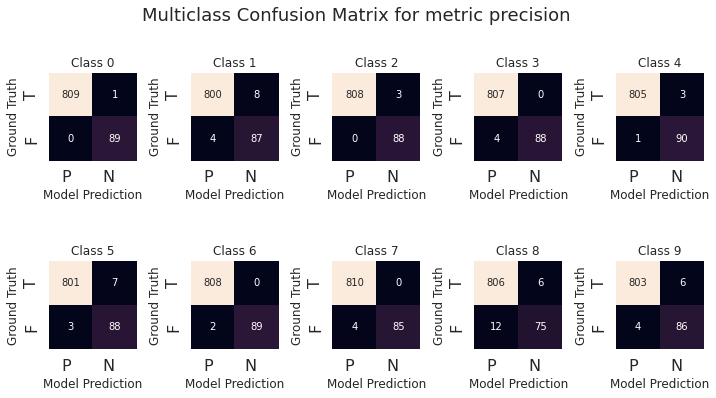


Finding the best hyperparameters for our MLR classifier based on the best recall score
Best parameters set found on development set:
{'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.93      0.96      0.94        91
           2       0.97      1.00      0.98        88
           3       1.00      0.96      0.98        92
           4       0.96      0.99      0.97        91
           5       0.93      0.98      0.95        91
           6       1.00      0.98      0.99        91
           7       1.00      0.96      0.98        89
           8       0.93      0.87      0.90        87
          

<Figure size 432x288 with 0 Axes>

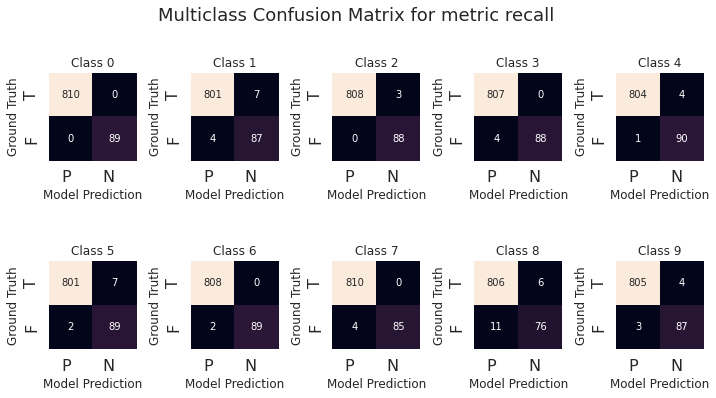


Finding the best hyperparameters for our MLR classifier based on the best f1 score
Best parameters set found on development set:
{'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.93      0.96      0.94        91
           2       0.97      1.00      0.98        88
           3       1.00      0.96      0.98        92
           4       0.96      0.99      0.97        91
           5       0.93      0.98      0.95        91
           6       1.00      0.98      0.99        91
           7       1.00      0.96      0.98        89
           8       0.93      0.87      0.90        87
           9  

<Figure size 432x288 with 0 Axes>

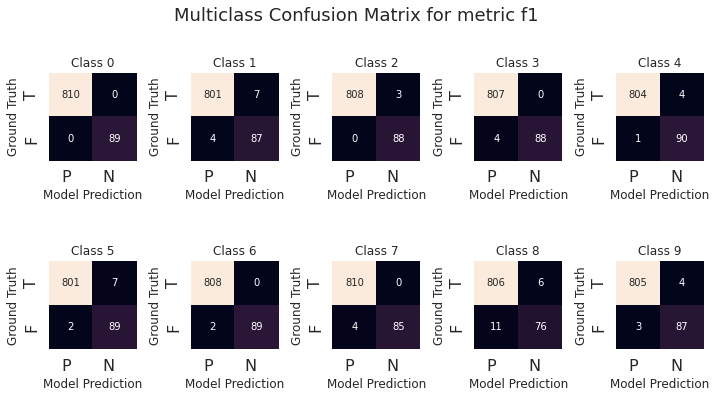


Finding the best hyperparameters for our MLR classifier based on the best jaccard score
Best parameters set found on development set:
{'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}


Detailed classification report:

The model is trained on the full development set.
 The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.93      0.96      0.94        91
           2       0.97      1.00      0.98        88
           3       1.00      0.96      0.98        92
           4       0.96      0.99      0.97        91
           5       0.93      0.98      0.95        91
           6       1.00      0.98      0.99        91
           7       1.00      0.96      0.98        89
           8       0.93      0.87      0.90        87
         

<Figure size 432x288 with 0 Axes>

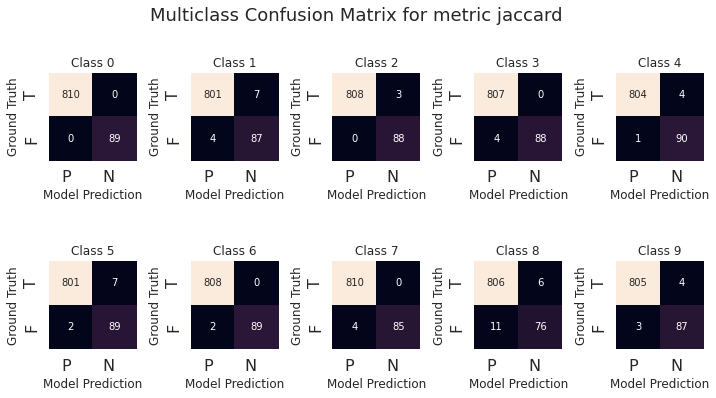


All possible results from our grid search for SVC classifier based on precision
	 0.961 (+/-0.021) for {'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001, 'warm_start': True}
	 0.961 (+/-0.021) for {'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001, 'warm_start': False}
	 0.964 (+/-0.029) for {'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}
	 0.964 (+/-0.029) for {'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': False}
	 0.953 (+/-0.009) for {'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty':

<Figure size 432x288 with 0 Axes>

In [ ]:
''' 
now let's try to create the same type of classifier, but utilize grid search to tune 
the classifier's hyperparameters
'''

# grid search parameters range and search cases
# See all possible parameters and their types, possible combinations, and their impact:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
searchCases = [
    {"multi_class": ["multinomial"], 
        "penalty": ["l2"],
        "solver": ["newton-cg", "lbfgs", "sag", "saga"],
        "random_state": [1, 7, 77],
        "fit_intercept": [True, False],
        "C": [1, 10, 1000],
        "tol": [1e-4, 1e1, 1e2],
        "max_iter": [1e5],
        "warm_start": [True, False]
        },
    {"multi_class": ["multinomial"], 
        "penalty": ["none"],
        "solver": ["newton-cg", "lbfgs", "sag", "saga"],
        "random_state": [1, 7, 77],
        "fit_intercept": [True, False],
        "tol": [1e-4, 1e1, 1e2],
        "max_iter": [1e5],
        "warm_start": [True, False]
        }
]

# these are the metrics we will use to rank each grid search result and 
# find the best possible outcome
metrics = ["precision", "recall", "f1", "jaccard"]
allResultsAllMetrics = []

for metric in metrics:
    allResultsPerMetric = []
    print(f"Finding the best hyperparameters for our MLR classifier based on the best {metric} score")

    # create model, and use grid search to tune the hyperparameters 
    classifier = GridSearchCV(LogisticRegression(), searchCases, scoring=f"{metric}_macro")
    
    # train model
    classifier.fit(X_train, y_train)

    # display best results found via grid search
    print(f"Best parameters set found on development set:\n{classifier.best_params_}\n\n")

    # display best parameters combination
    means = classifier.cv_results_["mean_test_score"]
    stds = classifier.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, classifier.cv_results_["params"]):
        allResultsPerMetric.append("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    # display detailed report of best case
    print("Detailed classification report:\n")
    print("The model is trained on the full development set.\n",
          "The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, classifier.predict(X_test)
    print(classification_report(y_true, y_pred), '\n\n')
    
    # plot confusion matrix
    fig, ax = plt.subplots(2, 5, figsize=(10, 6))
    for cfs_matrix, target, axes in zip(multilabel_confusion_matrix(y_true, y_pred),
                                        range(0,10),
                                        ax.flatten()):
        addSubPlotConfusionMatrix(cfs_matrix, axes, target)
    fig.suptitle(f'Multiclass Confusion Matrix for metric {metric}', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.clf()
    print()

    # append all result to the array to print it at the end
    allResultsAllMetrics.append(allResultsPerMetric)

# print all results (full verbosity)
for metric in range(len(allResultsAllMetrics)):
    print(f"All possible results from our grid search for SVC classifier based on {metrics[metric]}")
    for x in allResultsAllMetrics[metric]:
        print('\t', x)
    print()

### Observation
We first ran a simple MLR calssification model, then we attempted to run it again using grid-search. Our grid search cases were set based on the penlty parameter, as it's not possible to have non-default value for parameter `C` with a penelty value of `none`.

The best MLR model based on **percesion** score was **0.964 (96.4%)** with **+/-0.015** stdv for the following hyperparameters:
* `{'C': 1, 'fit_intercept': False, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 7, 'solver': 'saga', 'tol': 0.0001, 'warm_start': True}`

The best MLR model based on **recall** and **f1-score** was **0.961 (96.1%)** with **+/-0.031** stdv for the following hyperparameters:
* `{'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}`

The best MLR model based on **jaccard/similarity coefficient** score was **0.927 (92.7%)** with **+/-0.056** stdv for the following hyperparameters:
* `{'C': 1, 'fit_intercept': True, 'max_iter': 100000.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 10.0, 'warm_start': True}`



In [22]:
''' build and validate the best model found from grid search '''

# create multinomial logistic regression model with 5-folds cross validation
classifier = LogisticRegressionCV(cv=5, Cs=1,
                                fit_intercept=False,
                                max_iter=100000.0,
                                multi_class='multinomial',
                                penalty='l2',
                                random_state=7,
                                solver='saga', 
                                tol=0.0001)

# train model
classifier.fit(X, y)

# predict target values using our trained model
y_pred = classifier.predict(X)

# show classification report
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       178
           1       0.87      0.90      0.88       182
           2       0.97      0.96      0.96       177
           3       0.99      0.91      0.95       183
           4       0.98      0.96      0.97       181
           5       0.96      0.95      0.96       182
           6       0.98      0.97      0.97       181
           7       0.92      0.99      0.95       179
           8       0.90      0.84      0.87       174
           9       0.85      0.91      0.88       180

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797



## Part 3: Model comparison

Compare the two models. Which one did better and by how much?

### Solution
The same dataset, and sub-datasets (post test and train) where used to train and test both models (SVM and MLR). This was to ensure that the coparison is normalized with the only variation being the classification models type.

Additionally, we utilized grid search, to ensure that we tuned each model's hyperparameters to give the best possible performance. Performance was measured based on four metrics: percision, recall, f1-score, and Jaccard.

Generally, the SVM classification model performed better than the MLR. More specifically, the best SVM model scored anaccuracy of **99%**, where as the best MLR model scored an accuracy of **96-97%** (based on grid search metric). In addition, MLR had more false positives than SVM in most classes (see generated classififcation matrix plots for each question).

Therefore, we can conclude that SVM did better than MLR by ~2% in accuracy.